In [1]:
import yfinance as yf
import talib as ta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(symbol):
    stock_data = yf.Ticker(symbol)
    data = stock_data.history(period="5y", interval = '1d')
    return data

In [3]:
def add_stoch(data):
    high = data['High']
    low = data['Low']
    close = data['Close']
    # Calculate slow %K and slow %D
    slowk, slowd = ta.STOCH(high, low, close,fastk_period=5,slowk_period=3,slowk_matype=0,slowd_period=3,slowd_matype=0)

    return slowk, slowd

In [4]:
def add_macd(data):
    macd, macdsignal, macdhist = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    return macd, macdsignal, macdhist

In [5]:
def plot_macd(data, macd, macdsignal, macdhist):
    plt.figure(figsize=(12, 6))
    # Plotting MACD and MACD signal line
    plt.subplot(2, 1, 1)
    plt.plot(data.index, macd, label='MACD', color='blue')
    plt.plot(data.index, macdsignal, label='MACD Signal', color='red')
    plt.legend()

    # Plotting MACD histogram
    plt.subplot(2, 1, 2)
    plt.bar(data.index, macdhist, label='MACD Histogram', color='gray')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.legend()

    plt.show()

In [6]:
def implement_macd_strategy(data):
    macd, macdsignal, _ = ta.MACD(data['Close'])
    # Generate signals based on MACD crossovers with MACD signal line
    prices = data['Close']
    buy_price = [np.nan] * len(prices)
    sell_price = [np.nan] * len(prices)
    signals = [0] * len(prices)

    for i in range(1, len(macd)):
        if macd[i] > macdsignal[i] and macd[i - 1] <= macdsignal[i - 1]:
            buy_price[i] = prices[i]
            signals[i] = 1  # Buy signal
        elif macd[i] < macdsignal[i] and macd[i - 1] >= macdsignal[i - 1]:
            sell_price[i] = prices[i]
            signals[i] = -1  # Sell signal

    return buy_price, sell_price, signals

In [7]:
def plot_macd_strategy(symbol, prices, buy_price, sell_price, macd, macdsignal):
    ax1 = plt.subplot2grid((9, 1), (0, 0), rowspan=5, colspan=1)
    ax1.plot(prices, color='skyblue', label=symbol)
    ax1.plot(prices.index, buy_price, marker='^', color='green', markersize=10, label='BUY SIGNAL', linewidth=0)
    ax1.plot(prices.index, sell_price, marker='v', color='r', markersize=10, label='SELL SIGNAL', linewidth=0)
    ax1.legend(loc='upper left')
    ax1.set_title(f'{symbol} STOCK PRICE')
    
    plt.show()

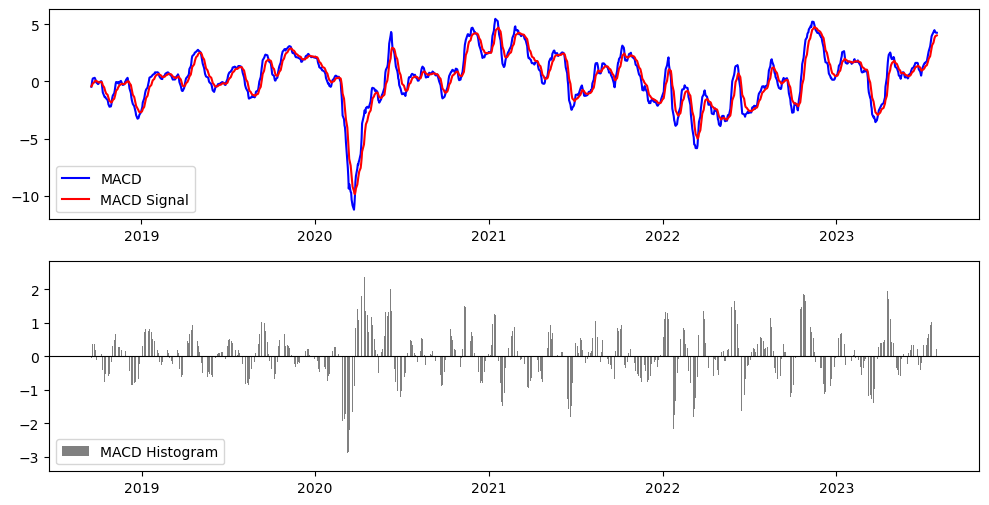

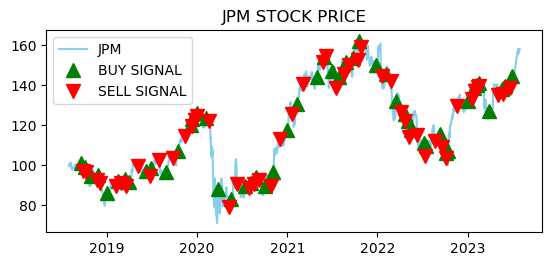

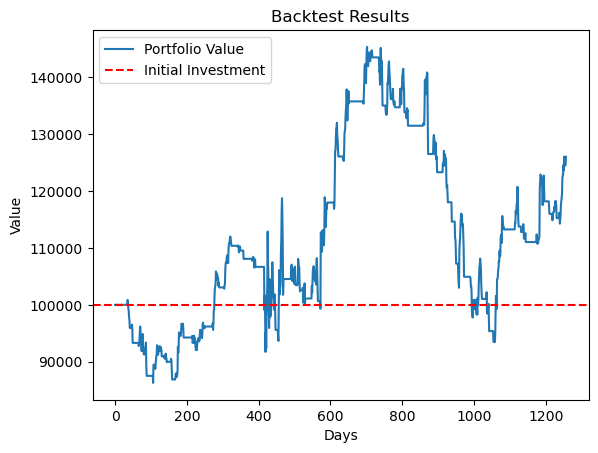

Total return: 26.02%


In [19]:
#testing code for MACD
symbol = 'JPM'
data = get_data(symbol)
prices = data['Close']
macd, macdsignal, macdhist = add_macd(data)
buy_price, sell_price, signal = implement_macd_strategy(data)
plot_macd(data, macd, macdsignal, macdhist)
plot_macd_strategy(symbol, prices, buy_price, sell_price, macd, signal)
backtest(prices, buy_price, sell_price, initial_investment=100000)

In [9]:
def implement_stoch_strategy(prices, k, d):
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)
            
    return buy_price, sell_price, stoch_signal

In [10]:
def plot_stochastic_strategy(symbol, prices, buy_price, sell_price, k, d):
    ax1 = plt.subplot2grid((9, 1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((9, 1), (6,0), rowspan=3, colspan=1)
    ax1.plot(prices, color='skyblue', label=symbol)
    ax1.plot(prices.index, buy_price, marker='^', color='green', markersize=10, label='BUY SIGNAL', linewidth=0)
    ax1.plot(prices.index, sell_price, marker='v', color='r', markersize=10, label='SELL SIGNAL', linewidth=0)
    ax1.legend(loc='upper left')
    ax1.set_title(f'{symbol} STOCK PRICE')
    ax2.plot(k, color='deepskyblue', linewidth=1.5, label='%K')
    ax2.plot(d, color='orange', linewidth=1.5, label='%D')
    ax2.axhline(80, color='black', linewidth=1, linestyle='--')
    ax2.axhline(20, color='black', linewidth=1, linestyle='--')
    ax2.set_title(f'{symbol} STOCH')
    ax2.legend()
    plt.show()

In [11]:
def backtest(prices, buy_price, sell_price, initial_investment=100000):
    cash = initial_investment
    shares = 0
    portfolio_values = []

    for i in range(len(prices)):
        if not np.isnan(buy_price[i]) and cash > prices[i]:
            shares += cash // prices[i]
            cash -= shares * prices[i]
        if not np.isnan(sell_price[i]) and shares > 0:
            cash += shares * prices[i]
            shares = 0
        portfolio_value = cash + shares * prices[i]
        portfolio_values.append(portfolio_value)

    total_return = (portfolio_values[-1] - initial_investment) / initial_investment
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.axhline(y=initial_investment, color='r', linestyle='--', label='Initial Investment')
    plt.legend()
    plt.title('Backtest Results')
    plt.xlabel('Days')
    plt.ylabel('Value')
    plt.show()

    print(f"Total return: {total_return * 100:.2f}%")

In [12]:
def analyze_stock(symbol):
    data = get_data(symbol)
    prices = data['Close']
    k, d = add_stoch(data)
    buy_price, sell_price, stoch_signal = implement_stoch_strategy(prices, k, d)
    plot_stochastic_strategy(symbol, prices, buy_price, sell_price, k, d)
    backtest(prices, buy_price, sell_price)

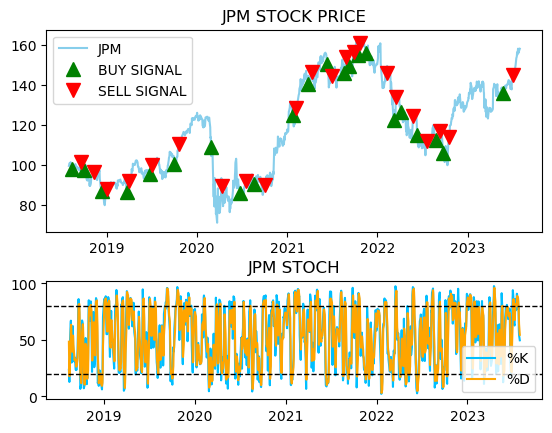

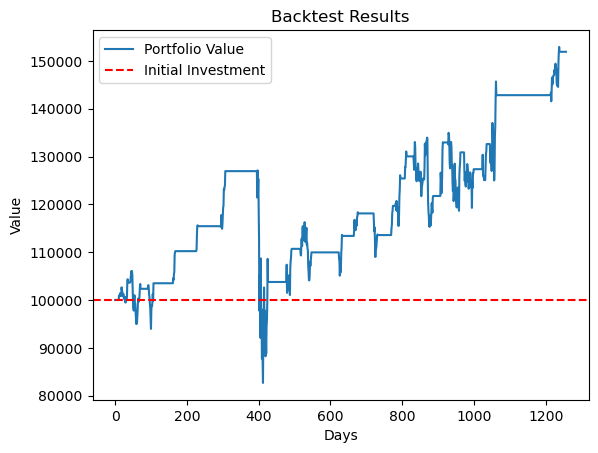

Total return: 51.89%


In [13]:
analyze_stock('JPM')

Analyzing TSLA...


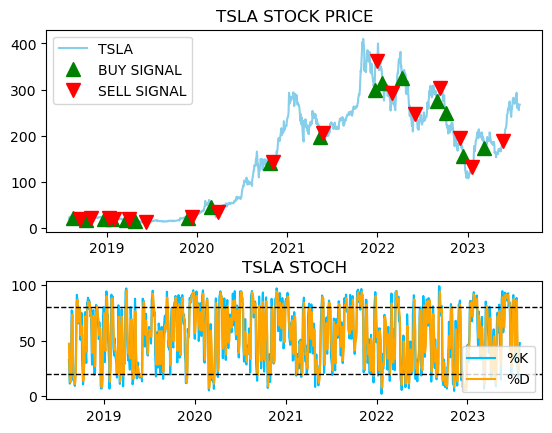

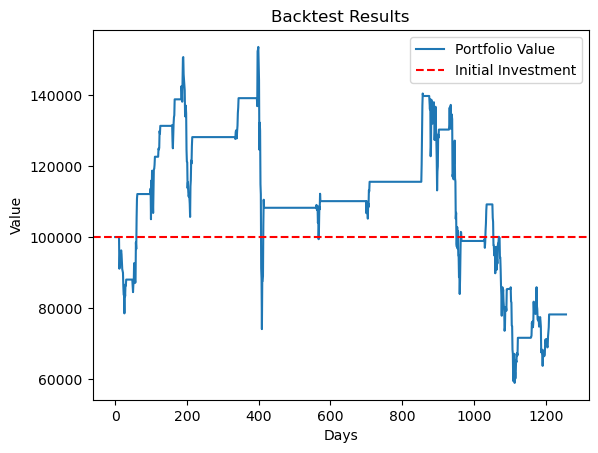

Total return: -21.83%
Analysis for TSLA completed.

Analyzing MSFT...


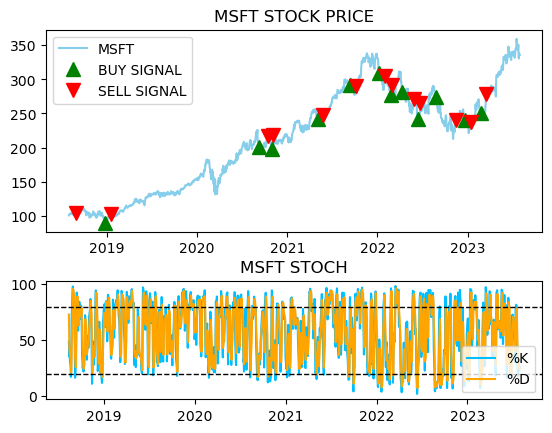

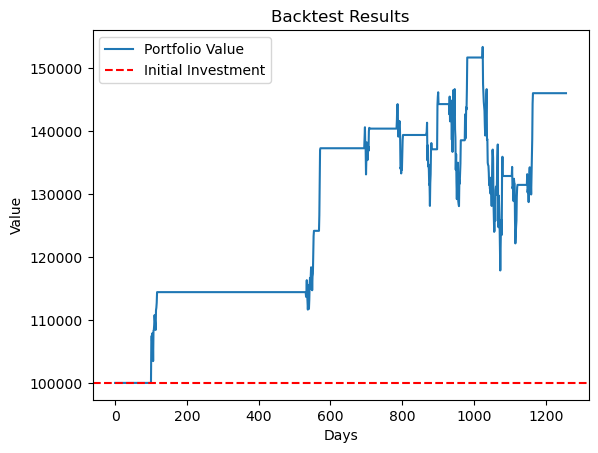

Total return: 46.04%
Analysis for MSFT completed.

Analyzing NVDA...


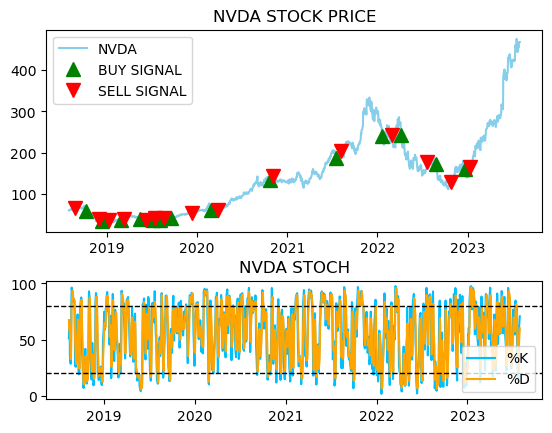

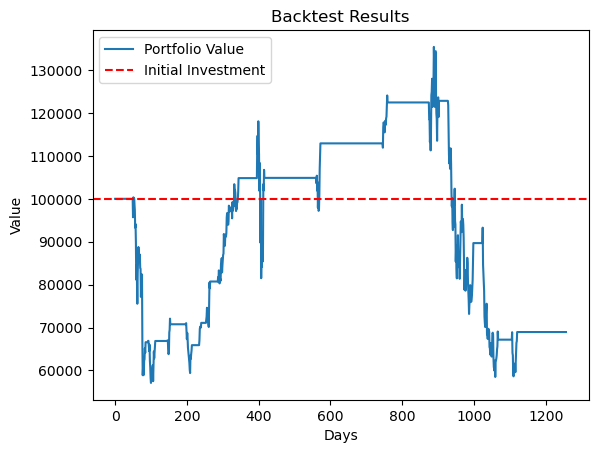

Total return: -31.04%
Analysis for NVDA completed.

Analyzing AAPL...


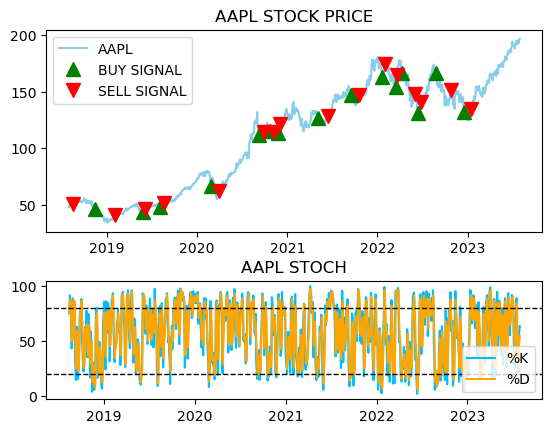

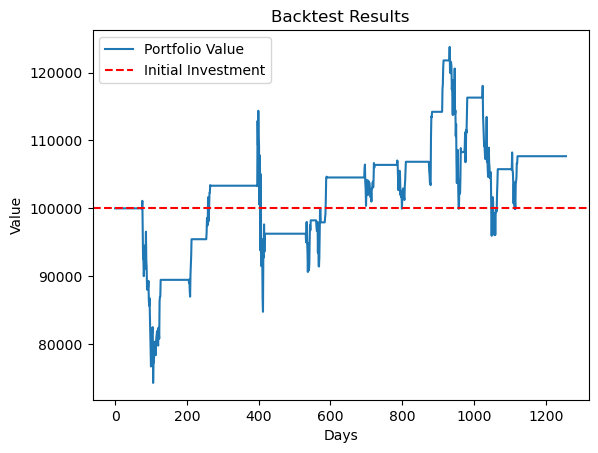

Total return: 7.68%
Analysis for AAPL completed.

Analyzing AMZN...


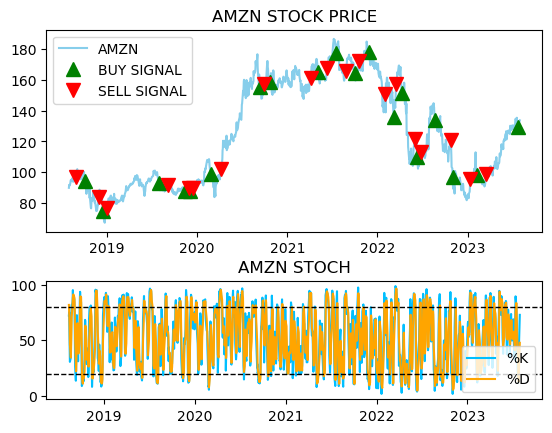

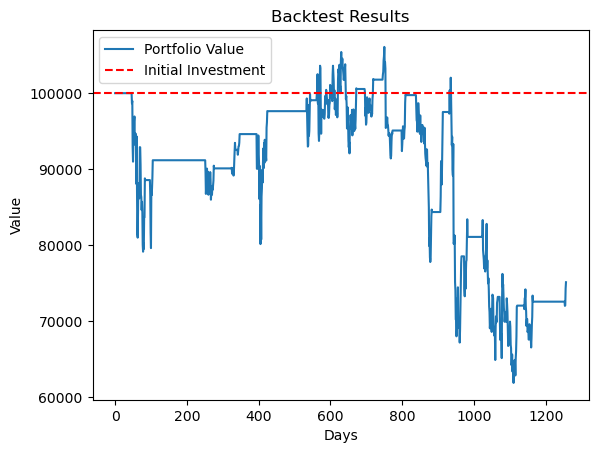

Total return: -24.87%
Analysis for AMZN completed.

Analyzing AMD...


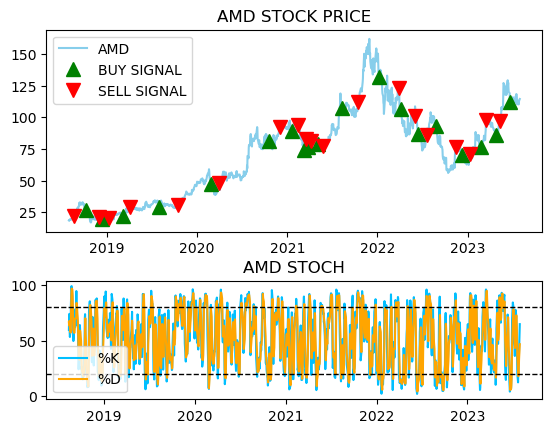

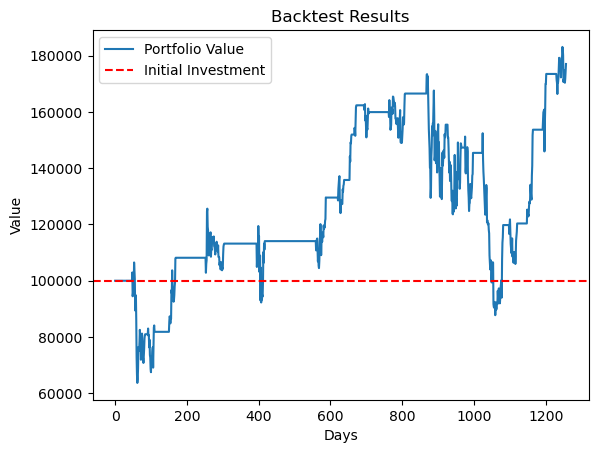

Total return: 77.04%
Analysis for AMD completed.

Analyzing TSM...


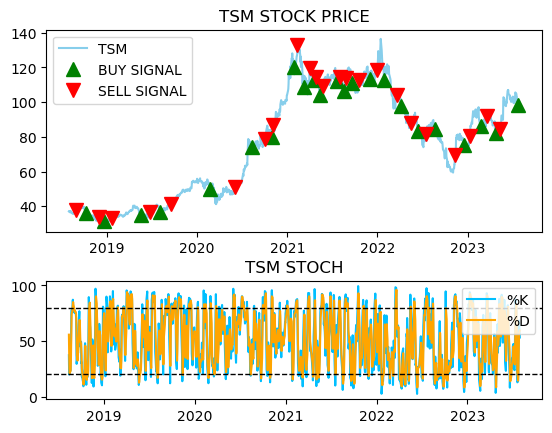

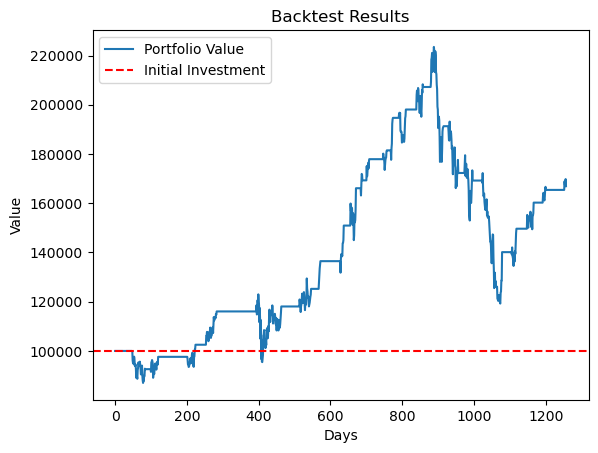

Total return: 66.92%
Analysis for TSM completed.



In [14]:
def main(stocks):
    for symbol in stocks:
        try:
            print(f"Analyzing {symbol}...")
            analyze_stock(symbol)
            print(f"Analysis for {symbol} completed.\n")
        except Exception as e:
            print(f"An error occurred while analyzing {symbol}: {e}\n")

# List of stock symbols to analyze
tech = ['TSLA', 'MSFT', 'NVDA', 'AAPL', 'AMZN', 'AMD','TSM']

# Calling the main function with the list of stocks
main(tech)

Analyzing JPM...


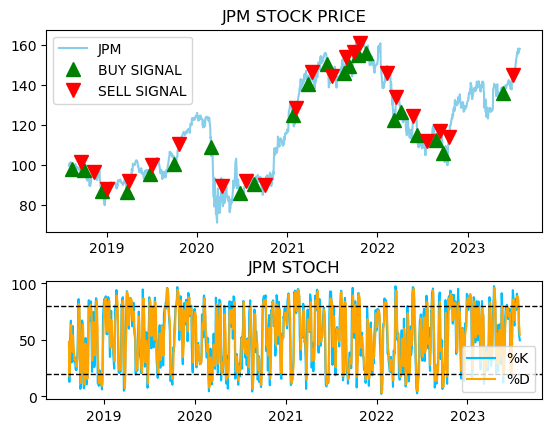

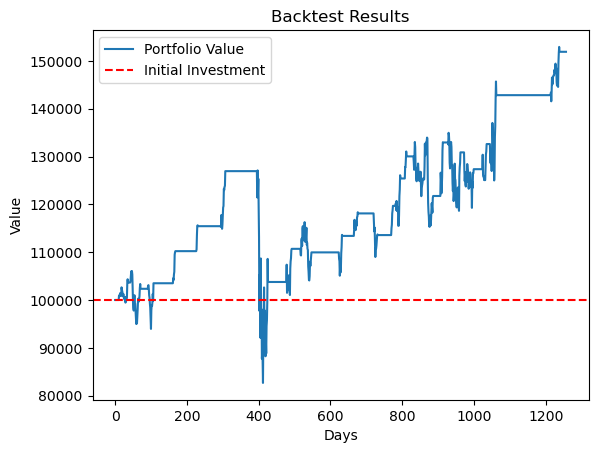

Total return: 51.89%
Analysis for JPM completed.

Analyzing BAC...


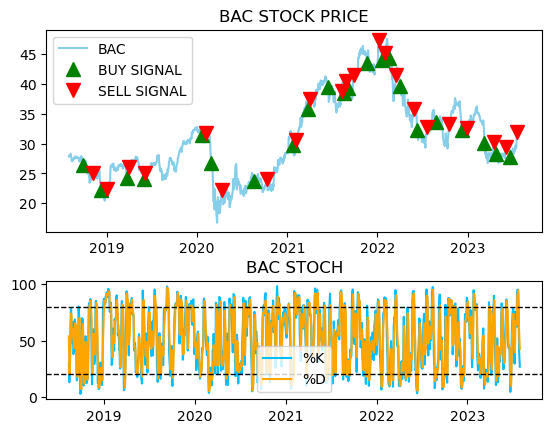

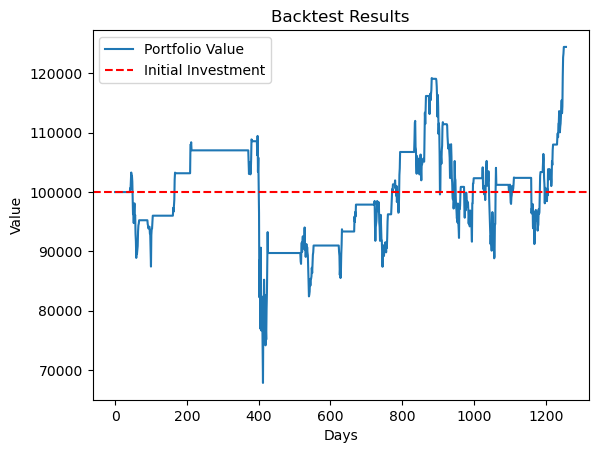

Total return: 24.47%
Analysis for BAC completed.

Analyzing C...


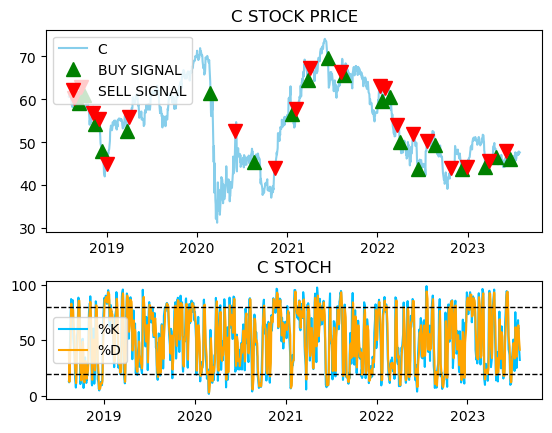

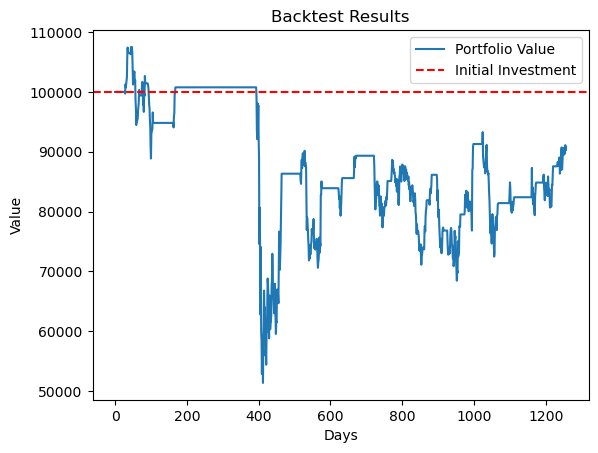

Total return: -9.32%
Analysis for C completed.

Analyzing V...


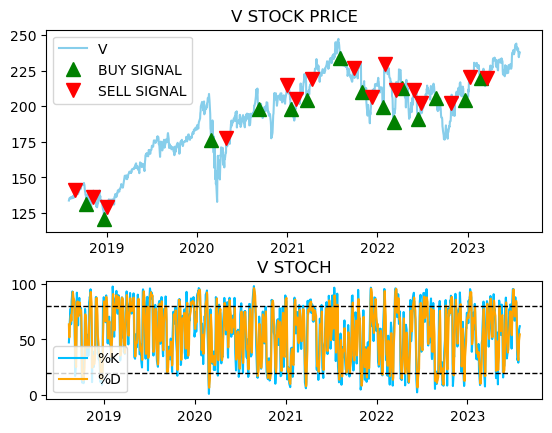

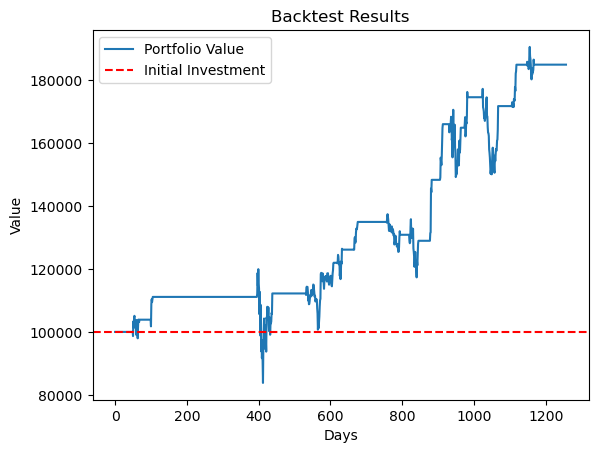

Total return: 84.89%
Analysis for V completed.

Analyzing MA...


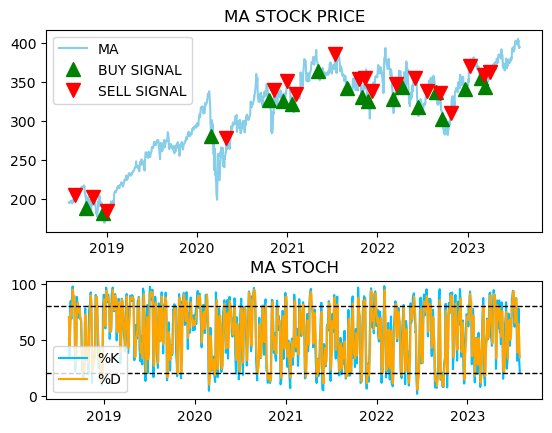

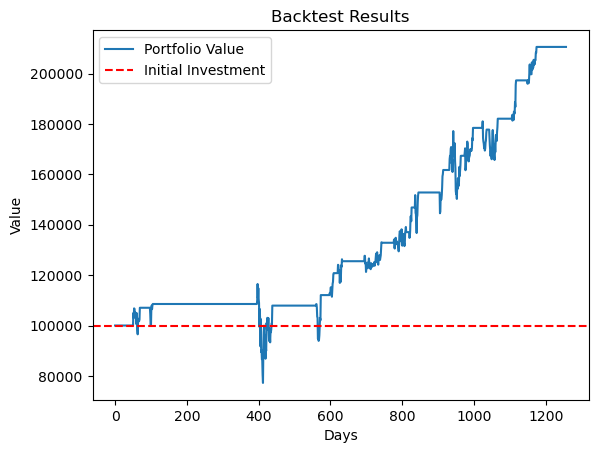

Total return: 110.56%
Analysis for MA completed.

Analyzing MS...


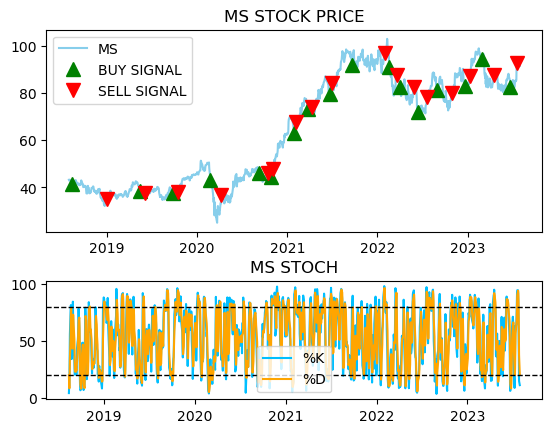

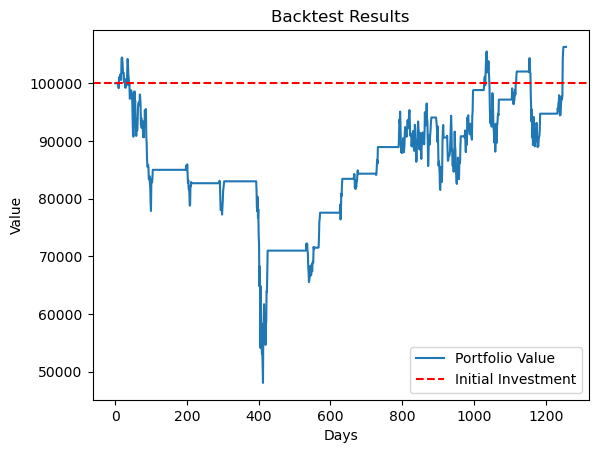

Total return: 6.29%
Analysis for MS completed.

Analyzing GS...


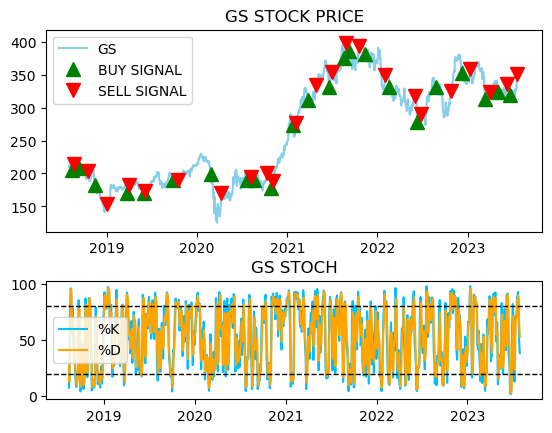

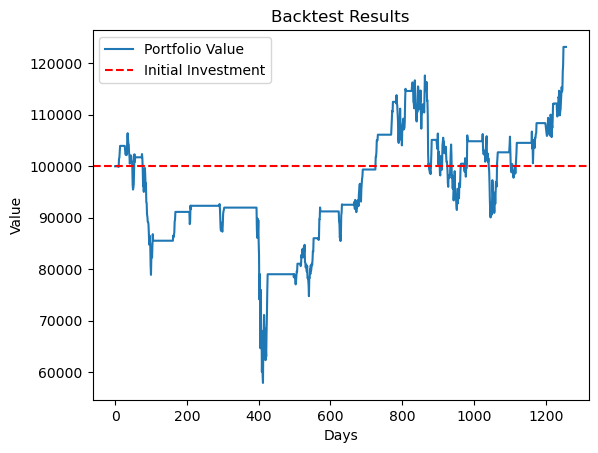

Total return: 23.18%
Analysis for GS completed.

Analyzing PYPL...


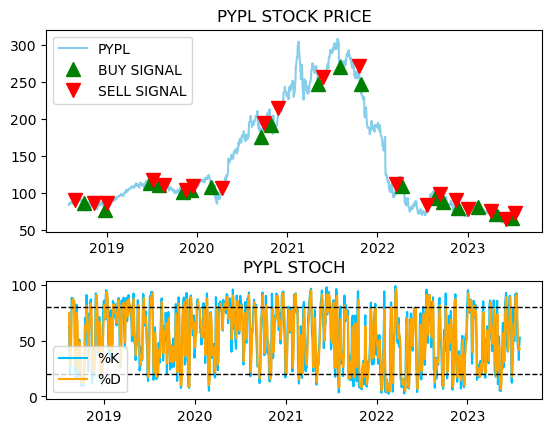

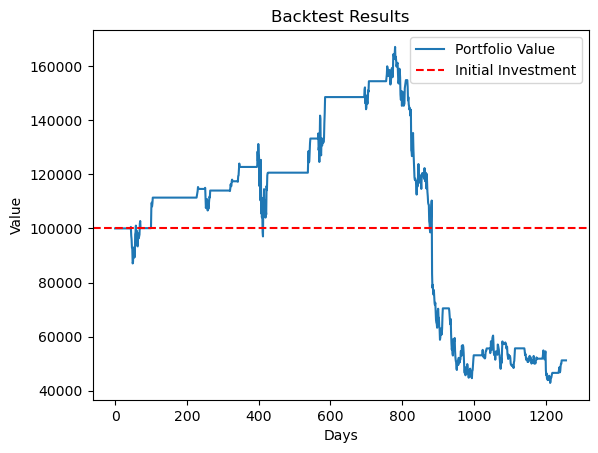

Total return: -48.77%
Analysis for PYPL completed.



In [15]:
finance = ['JPM', 'BAC', 'C', 'V', 'MA', 'MS','GS','PYPL']
main(finance)

Analyzing MRNA...


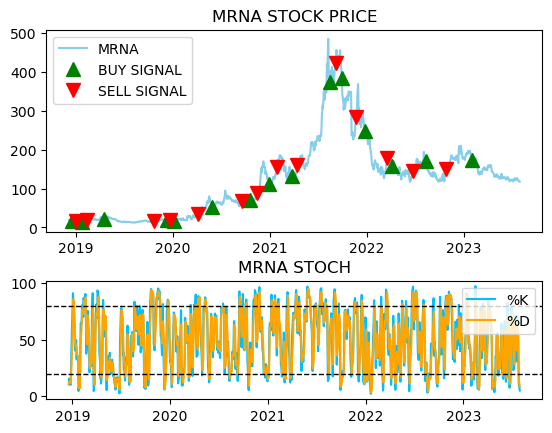

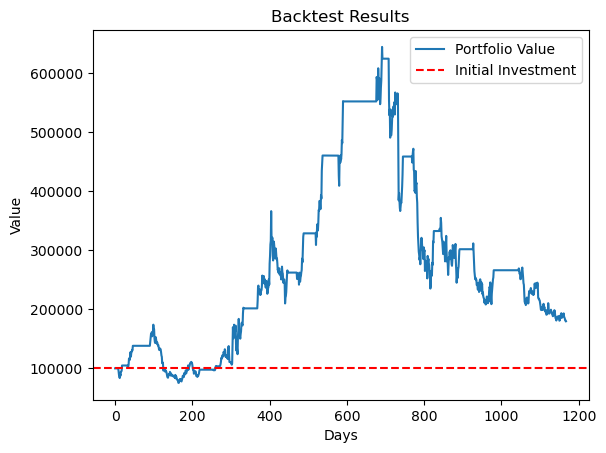

Total return: 79.80%
Analysis for MRNA completed.

Analyzing PFE...


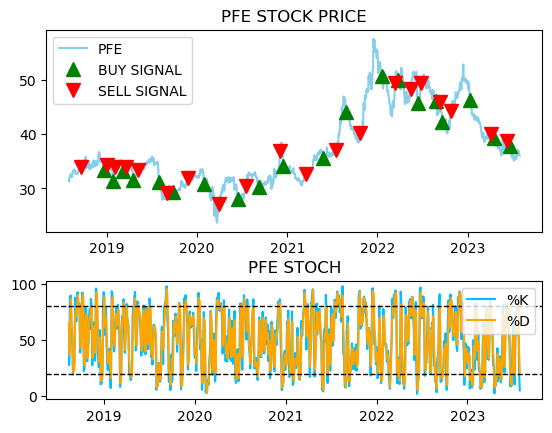

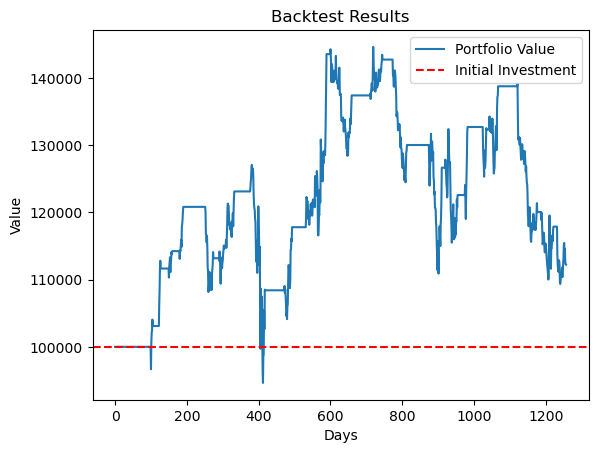

Total return: 12.23%
Analysis for PFE completed.

Analyzing ILMN...


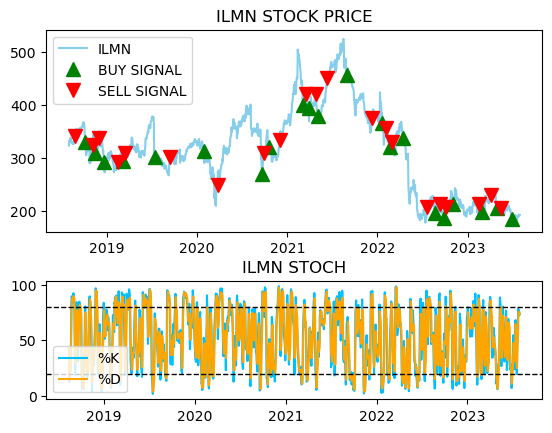

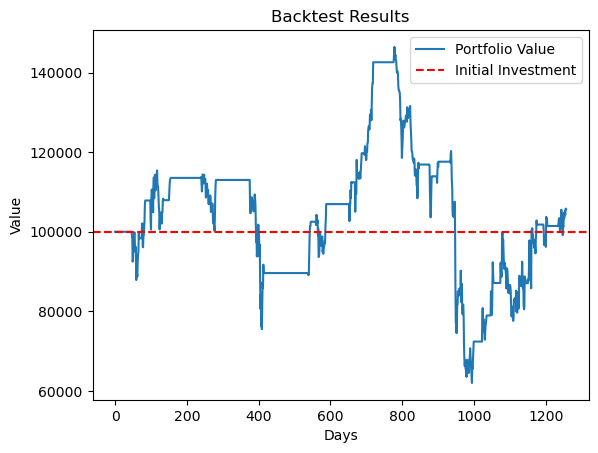

Total return: 5.65%
Analysis for ILMN completed.

Analyzing TMO...


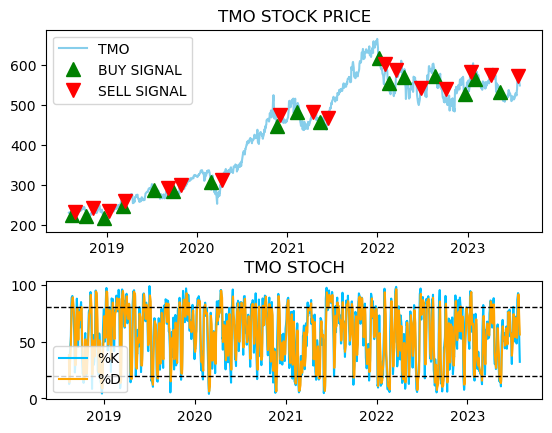

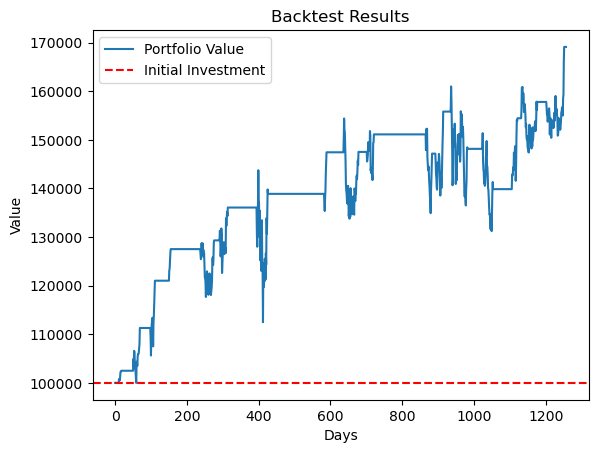

Total return: 69.13%
Analysis for TMO completed.

Analyzing RGNX...


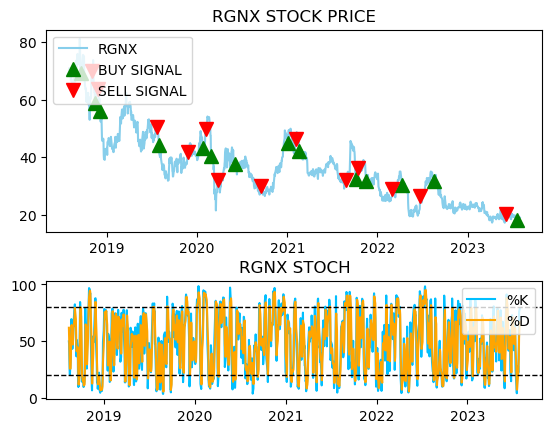

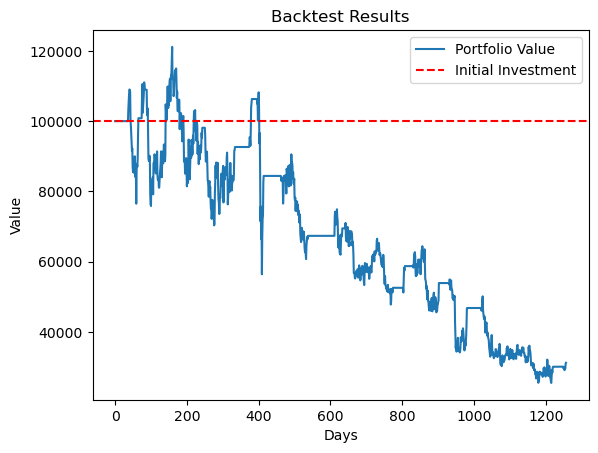

Total return: -68.76%
Analysis for RGNX completed.

Analyzing VRTX...


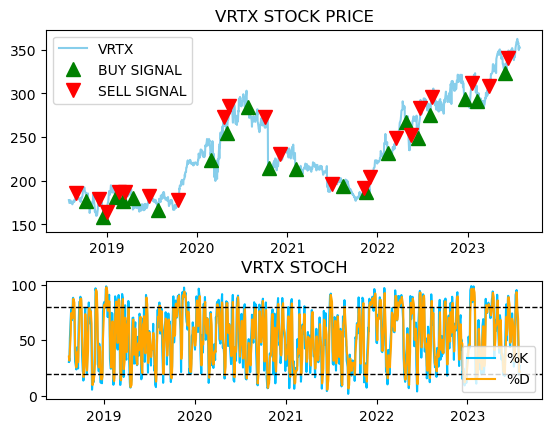

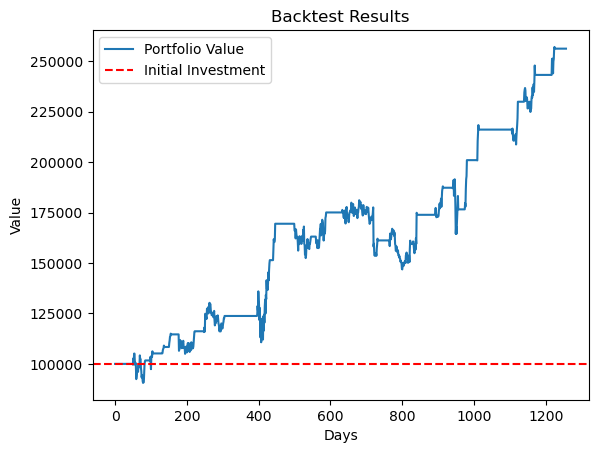

Total return: 156.29%
Analysis for VRTX completed.

Analyzing BNTX...


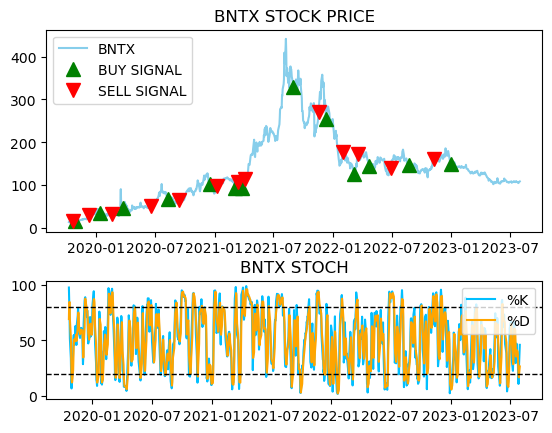

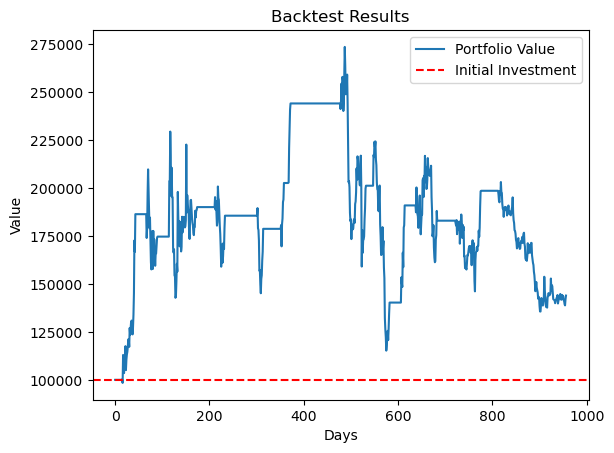

Total return: 43.94%
Analysis for BNTX completed.

Analyzing BIIB...


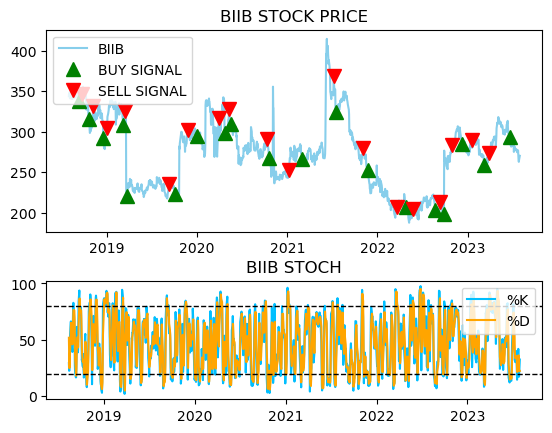

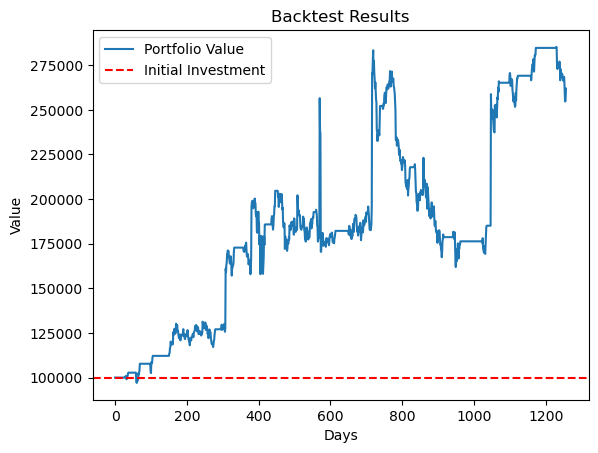

Total return: 161.82%
Analysis for BIIB completed.



In [16]:
bio = ['MRNA', 'PFE', 'ILMN', 'TMO', 'RGNX', 'VRTX', 'BNTX', "BIIB"]
main(bio)